# VAE Troubleshooting –– 2

WNixalo – 2016/6/20

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai.conv_learner import *

## 1. Setup

In [3]:
input_size   = 784
encoding_dim = 32
bs = 16
tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]

In [4]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

In [5]:
# create copies of dataloaders for ModelData
train_loadermd = copy.deepcopy(train_loader)
test_loadermd  = copy.deepcopy(test_loader)

# set y to be x and convert [0,255] int to [0.0,1.0] float. (dl doesnt trsfm `y` by default)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_data.type(torch.FloatTensor)/255
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_data.type(torch.FloatTensor)/255

# add channel dimension for compatibility. (bs,h,w) –> (bs,ch,h,w)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_labels.reshape((len(train_loadermd.dataset),1,28,28))
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_labels.reshape((len(test_loadermd.dataset),1,28,28))

In [6]:
md = ModelData('data/MNIST', train_loadermd, test_loadermd)

In [8]:
def compare_batch(x, z, bs=16, figsize=(16,2)):
    bs = min(len(x), bs) # digits to display
    fig = plt.figure(figsize=figsize)
    for i in range(bs):
        # display original
        ax = plt.subplot(2, bs, i+1); ax.imshow(x[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, bs, i+1+bs); ax.imshow(z[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
def space_plot(model):
    model.eval()
    plt.figure(figsize=(6,6)); plt.style.use('classic');

    for x,y in iter(test_loader):
        z, μ, logvar, enc_x = model(x)

        plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
    plt.colorbar(); plt.style.use('default');
    
def model_plots(model, dataloader):
    x,y = next(iter(dataloader))
    z = model(x)
    if len(z) > 1: print([zi.shape for zi in z]);
    compare_batch(x,z[0].detach())
    space_plot(model)

In [ ]:
learner.model.encoder.

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [62]:
class VEncoder(nn.Module):
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.fc0  = nn.Linear(input_size, interm_size)
        self.fc10 = nn.Linear(interm_size, latent_size)
        self.fc11 = nn.Linear(interm_size, latent_size)
#         self.debug=False
    
    def forward(self, x):
#         if self.debug:pdb.set_trace()###################################TRACE
        h1   = F.relu(self.fc0(x))
        μ    = F.relu(self.fc10(h1))
        logv = F.relu(self.fc11(h1))
        return μ, logv

# class VSampler(nn.Module):
#     def __init__(self):
#         super().__init__()
# #         self.debug=False
    
#     def forward(self, μ, logv):
# #         if self.debug:pdb.set_trace()###################################TRACE
#         if self.training:
#             σ = torch.exp(0.5*logv)
#             ε = torch.randn_like(σ)
#             return ε.mul(σ).add_(μ)
#         else:
#             return μ
        
class VDecoder(nn.Module):
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.fc2 = nn.Linear(latent_size, interm_size)
        self.fc3 = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        h3 = F.relu(self.fc2(x))
        z  = F.sigmoid(self.fc3(h3))
        return z
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=512, latent_shape=2):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
        
    def reparameterize(self, μ, logv):
        if self.training:
            σ = torch.exp(0.5*logv)
            ε = torch.randn_like(σ)
            return ε.mul(σ).add_(μ)
        else:
            return μ
    
    def forward(self, x):
#         pdb.set_trace()
        x = x.view(x.size(0), -1) # flatten
        μ,logv = self.encoder(x)
#         enc = self.sampler(μ, logv)
        enc = self.reparameterize(μ, logv)
        z = self.decoder(enc)
        z = z.view(z.size(0), 1, 28, 28)
        return z, μ, logv, enc

In [61]:
def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return KLD + BCE

 50%|████▉     | 1861/3750 [01:20<01:21, 23.25it/s, loss=0.263]

In [11]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=True)

In [81]:
def loss_function(recon_x, mu, logvar, x):
    BCE = F.binary_cross_entropy(recon_x.view(recon_x.size(0),-1), x.view(x.size(0), -1), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, epoch, log_interval=100):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, enc = model(data)
        loss = loss_function(recon_batch, mu, logvar, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [73]:
def learner_test(eps=3, crit=F.binary_cross_entropy, learn=None):
    if learn is None: learn = Learner.from_model_data(VariationalAutoencoder(), md)
    learn.crit   = crit
    learn.opt_fn = torch.optim.Adam
    learn.reg_fn = vae_loss
    learn.fit(1e-3, eps)
    return learn

def pytorch_test(eps=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = VariationalAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for i in range(1,eps+1): train(i, log_interval=800)
    return model

## 2. Testing

In [30]:
learner = learner_test(1)

epoch      trn_loss   val_loss                                 
    0      0.263303   0.263635  


[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


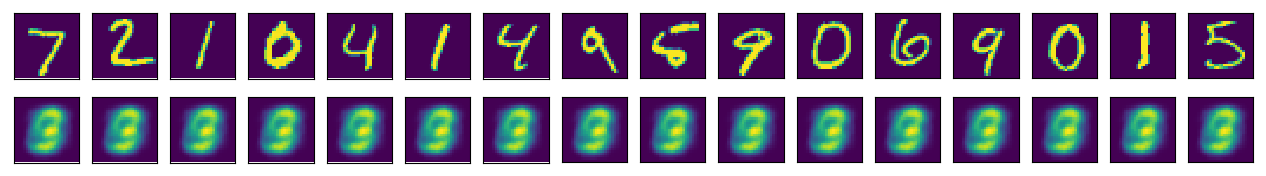

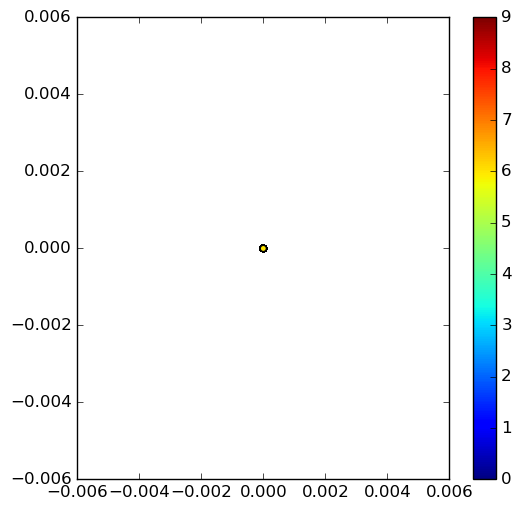

In [31]:
model_plots(learner.model, learner.data.val_dl)

In [33]:
learner.model.encoder.debug=True
learner.fit(1e-3,1)

  0%|          | 0/3750 [00:00<?, ?it/s]> <ipython-input-29-fcc3b57df3df>(11)forward()
-> h1   = F.relu(self.fc0(x))
(Pdb) n
> <ipython-input-29-fcc3b57df3df>(12)forward()
-> μ    = F.relu(self.fc10(h1))
(Pdb) h1
tensor([[ 0.1237,  0.0000,  0.3524,  ...,  0.0000,  0.1746,  0.3325],
        [ 0.5785,  0.0000,  0.1185,  ...,  0.0000,  0.2708,  0.5480],
        [ 0.7210,  0.0000,  0.2678,  ...,  0.0000,  0.6898,  0.3797],
        ...,
        [ 0.3537,  0.0000,  0.0433,  ...,  0.0000,  0.4335,  0.2480],
        [ 0.7537,  0.0000,  0.0000,  ...,  0.0000,  0.3619,  0.3342],
        [ 0.7322,  0.0000,  0.0000,  ...,  0.0000,  0.1281,  0.6240]])
(Pdb) n
> <ipython-input-29-fcc3b57df3df>(13)forward()
-> logv = F.relu(self.fc11(h1))
(Pdb) n
> <ipython-input-29-fcc3b57df3df>(14)forward()
-> return μ, logv
(Pdb) μ
tensor([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
     

BdbQuit: 

In [35]:
learner.model.encoder.debug=False

In [36]:
x,y = next(iter(test_loader))
learner.model(x)

(tensor([[[[ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           ...,
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002]]],
 
 
         [[[ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0001,  0.0002],
           [ 0.0001,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0001,  0.0001,  ...,  0.0002,  0.0001,  0.0002],
           ...,
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
           [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0001]]],
 
 
         [[[ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
       

In [38]:
learner.model.encoder(x.view(x.size(0),-1))

(tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]), tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]))

In [50]:
def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
#     KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
#     return KLD + BCE
    return BCE
learner = learner_test(1)

epoch      trn_loss   val_loss                                 
    0      0.200189   0.197971  


In [51]:
learner.model.encoder(x.view(x.size(0),-1))

(tensor([[ 39.6811,  54.8058],
         [  8.5279,   8.3201],
         [ 52.0876,  18.8047],
         [  4.0168,   0.9069],
         [  5.1902,  20.5346],
         [ 60.7905,  21.9507],
         [ 14.2416,  20.6902],
         [  5.0692,  15.7911],
         [ 10.3489,  14.0058],
         [ 50.6782,  56.1131],
         [  0.8408,   3.3885],
         [  1.4121,   6.4324],
         [ 22.5180,  39.7726],
         [  2.5068,   3.9280],
         [ 47.2428,   5.7846],
         [  4.8819,   7.8214]]), tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]))

In [63]:
def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
#     KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
#     return KLD + BCE
    return BCE

learner = learner_test(1)
learner.model.encoder(x.view(x.size(0),-1))

epoch      trn_loss   val_loss                                 
    0      0.229597   0.227302  


(tensor([[  0.0000,  22.7626],
         [  0.0000,   7.9820],
         [  0.0000,  74.2429],
         [  0.0000,   0.0091],
         [  0.0000,  15.0315],
         [  0.0000,  81.3699],
         [  0.0000,  18.4400],
         [  0.0000,  14.6482],
         [  0.0000,  12.9238],
         [  0.0000,  24.8688],
         [  0.0000,   0.0000],
         [  0.0000,   4.9459],
         [  0.0000,  23.3812],
         [  0.0000,   0.0000],
         [  0.0000,  59.2583],
         [  0.0000,   7.7050]]), tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]))

In [82]:
eps=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torchmodel  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(torchmodel.parameters(), lr=1e-3)
for i in range(1,eps+1): train(torchmodel, i, log_interval=800)

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.130920
Train Epoch: 1 [12800/60000 (21%)]	Loss: 210.804657
Train Epoch: 1 [25600/60000 (43%)]	Loss: 220.620148
Train Epoch: 1 [38400/60000 (64%)]	Loss: 219.220566
Train Epoch: 1 [51200/60000 (85%)]	Loss: 198.152267
====> Epoch: 1 Average loss: 208.5083


In [83]:
torchmodel.encoder(x.view(x.size(0),-1))

(tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]), tensor([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]))

[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


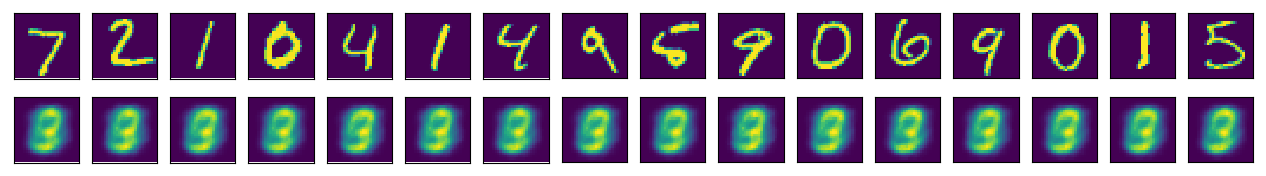

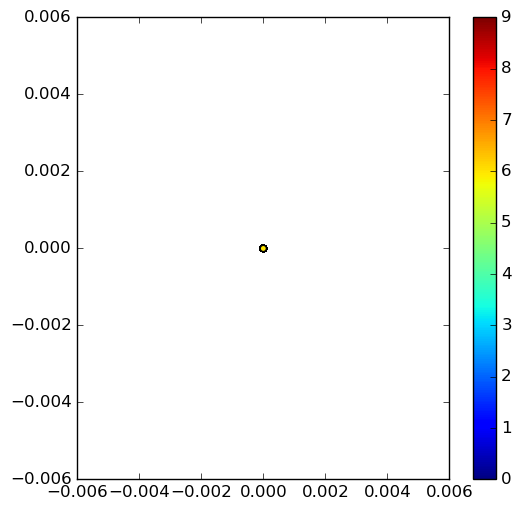

In [84]:
model_plots(torchmodel, learner.data.val_dl)

In [85]:
for i in range(5): train(torchmodel, i, log_interval=800)

Train Epoch: 0 [0/60000 (0%)]	Loss: 215.349258
Train Epoch: 0 [12800/60000 (21%)]	Loss: 213.444672
Train Epoch: 0 [25600/60000 (43%)]	Loss: 215.119888
Train Epoch: 0 [38400/60000 (64%)]	Loss: 206.195587
Train Epoch: 0 [51200/60000 (85%)]	Loss: 198.828613
====> Epoch: 0 Average loss: 206.6215
Train Epoch: 1 [0/60000 (0%)]	Loss: 219.428558
Train Epoch: 1 [12800/60000 (21%)]	Loss: 220.771057
Train Epoch: 1 [25600/60000 (43%)]	Loss: 205.493240
Train Epoch: 1 [38400/60000 (64%)]	Loss: 209.397415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 200.104156
====> Epoch: 1 Average loss: 206.4235
Train Epoch: 2 [0/60000 (0%)]	Loss: 190.869431
Train Epoch: 2 [12800/60000 (21%)]	Loss: 193.624008
Train Epoch: 2 [25600/60000 (43%)]	Loss: 201.482544
Train Epoch: 2 [38400/60000 (64%)]	Loss: 193.122543
Train Epoch: 2 [51200/60000 (85%)]	Loss: 194.865173
====> Epoch: 2 Average loss: 206.3377
Train Epoch: 3 [0/60000 (0%)]	Loss: 216.382843
Train Epoch: 3 [12800/60000 (21%)]	Loss: 214.837494
Train Epoch: 3 [25600/

[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


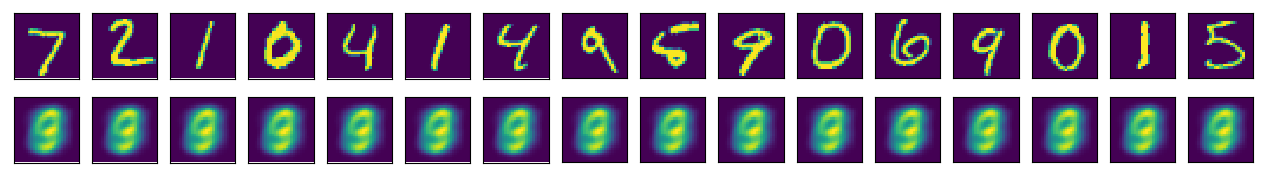

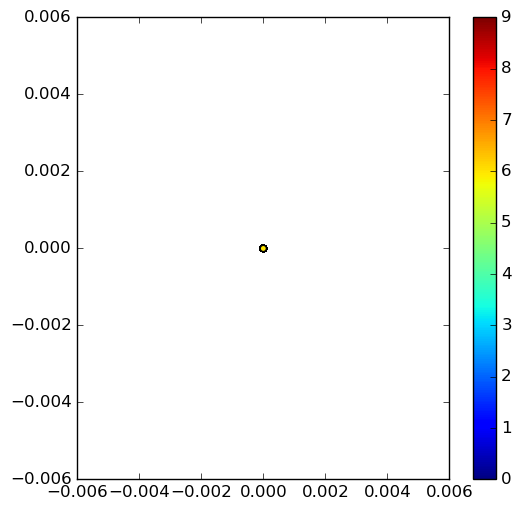

In [86]:
torchmodel.encoder(x.view(x.size(0),-1))
model_plots(torchmodel, learner.data.val_dl)

Alright jury's out. I have to redo this. Later.